## <b>Importing Libraries</b>

<p>
<code>os</code> for file and directory operations.
<code>random</code> for randomizing data.
<code>cv2</code> (OpenCV) for image processing.
<code>tqdm</code> for displaying progress bars.
<code>numpy</code> for numerical operations.
<code>matplotlib.pyplot</code> for plotting.
<code>PIL</code> for image processing.
</p>

In [2]:
import os
import random
import cv2 as cv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
import nbformat
from PIL import Image
import math 

<p>
OpenCV wasn't installed so installed and checked verison using the below code
</p>

In [3]:
print("OpenCV version:", cv.__version__)

OpenCV version: 4.10.0


## <b>Preparing Data</b>

<p>
<code>TRAIN_DIR</code> specifies the directory containing training data.
CATEGORIES is a list that stores the names of the categories (classes) found in the training directory.
Loading the CIFAR - 10 dataset from the workspace also displaying the class names. The dataset has 3 classes <code>cats</code>,<code>dogs</code>,<code>panda</code>
</p>

In [4]:
TRAIN_DIR = 'C:/Users/Tahsin/Desktop/mid/data'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['cats', 'dogs', 'panda']


<p>
Reading and storing every images from each class folder and recording them under the <code>TRAIN_DATA</code>.
This code snippet is designed to create a training dataset for a machine learning model. It iterates through a directory containing images categorized into different subdirectories, loads each image, resizes it, and stores it along with its corresponding class label in a list.
</p>

In [5]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR, c)
    # Gets the numerical index of the current category in the CATEGORIES list. 
    # This will be used as the class label.
    class_num = CATEGORIES.index(c)                   
    # Iterates through all image files in the current category's directory, using tqdm for a progress bar.
    for img in tqdm(os.listdir(path)):                                              
        img_arr = cv.imread(os.path.join(path, img))
        
        # Resize image to 32x32 using bilinear interpolation
        img_arr = cv.resize(img_arr, (32, 32), interpolation=cv.INTER_AREA)         
        
        # Appends the resized image array and its corresponding class label to the TRAIN_DATA list.
        TRAIN_DATA.append([img_arr, class_num])                                     
print(len(TRAIN_DATA))

100%|██████████| 1000/1000 [00:09<00:00, 103.84it/s]

3000


In [6]:
# Testing
# print(TRAIN_DATA)

Text(0.5, 0, 'cats')

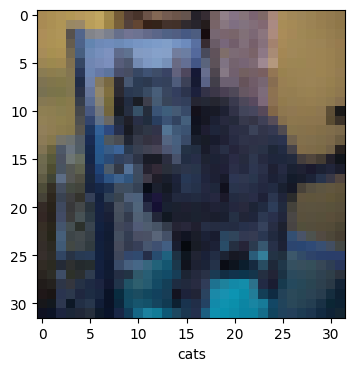

In [7]:
# Testing
image = TRAIN_DATA[0][0] 
plt.figure(figsize=(4,4)) 
plt.imshow(image)
plt.xlabel(CATEGORIES[TRAIN_DATA[0][1]])
plt.xlabel(CATEGORIES[TRAIN_DATA[0][1]])

<p>
Shuffling the training data, selects the first 50 images, converts them to grayscale, and displays them in a 5x10 grid with their corresponding class labels as captions. This helps visualize the variety of images and categories present in your training dataset.

First element is the feature vector (numerical data) <br>
Second element is the class label <br>
</p>

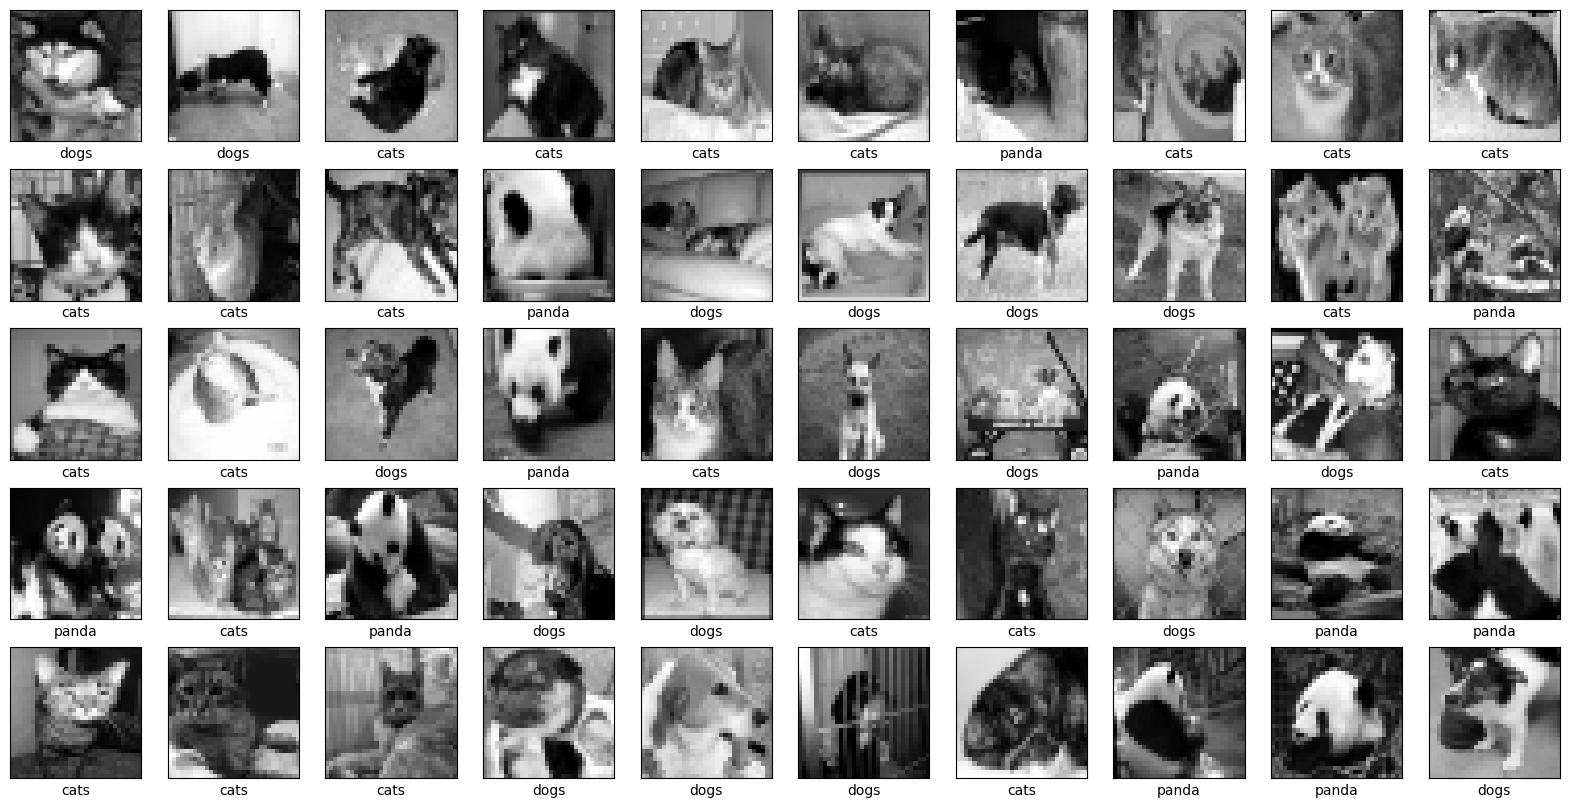

In [8]:
# Shuffling ensures that the displayed images are not biased towards the order they were loaded in.
random.shuffle(TRAIN_DATA)
# 20 inches wide and 10 inches tall                                                  
plt.figure(figsize=(20,10))                                                   

for i in range(50):
  # A grid layout with 5 rows and 10 columns. 
  # The i+1 argument defines the position of the current subplot within the grid
  plt.subplot(5, 10, i+1)             
  # Each element in TRAIN_DATA is a list containing an image array and a class label. 
  # Here, [0] selects the image array.                                        
  image = TRAIN_DATA[i][0]                        
  # Convert image to grayscale                            
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)                          
  plt.imshow(image_gray, cmap="gray")
  # [1] selects the image array label.
  plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
  plt.xticks([])
  plt.yticks([])
  plt.axis()
  if i == 50:
    break
plt.show()


<p>
Dividing a larger dataset, <code>TRAIN_DATA</code>, into five equal-sized fold. Each fold contain 600
</p>

In [9]:
f1 = TRAIN_DATA[0:600]
f2 = TRAIN_DATA[600:1200]
f3 = TRAIN_DATA[1200:1800]
f4 = TRAIN_DATA[1800:2400]
f5 = TRAIN_DATA[2400:3000]

<p>
<code>by_l1_dist(list)</code> and <code>by_l2_dist(list)</code>: These functions are used to sort lists based on their L1 and L2 distances respectively. They extract the L1 or L2 distance from the third element of the list.
</p>

In [10]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]

<p>
<code>l1_result</code> and <code>l2_result</code> are empty lists to store calculated distances.

Calculates L1 and L2 distances between each data point in the validation set and all data points in the training set. Iterates over each validation data point. For each validation point, calculates L1 and L2 distances to all training points. Stores the distances, class labels of both points, and calculated distances in a list. Sorts the list by L1 and L2 distances, respectively. Keeps the top <code>top_filter</code> nearest neighbors for both L1 and L2 distances. Returns a list containing L1 and L2 distance results.
</p>

In [11]:
top_filter = 20
def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold): 
        temp_dist_list = []
        for train in train_fold: 
            l1_dist = np.sum(np.abs(valid[0]-train[0]))
            l2_dist = np.sqrt(np.sum(valid[0]-train[0]**2))
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])
        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]

<p>
Calculates the accuracy of the KNN classifier for different values of K. Iterates over different values of K (from 1 to <code>k_range</code>). For each K, iterates over the validation set. Finds the K nearest neighbors for the current validation point. Counts the number of neighbors with the same class as the validation point. If K is odd, majority voting determines the predicted class. If K is even and there's a tie, the class with the smallest total distance is chosen. Calculates the accuracy for the current K. Stores the accuracy for the current K.
</p>

In [12]:
k_range = 20
def cal_accuracy(dist_result, dist_term):
    k_accuracies = []  
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:                      
                if ((k-1) / 2) < same_class_len:  
                    img_accuracy += 1
            else:                                  
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):    
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:   
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies

## <b>Cross Validation</b>

<p>
Performing 5-fold cross validation to compute distances for each fold. Defines training and validation sets for each fold. Calculates distances using distance_calc. Stores the results in <code>dist_by_fold</code>.
</p>

In [13]:
dist_by_fold = []

for i in range(1,6,1):
    if i == 0:
        train = f1 + f2 + f3 + f4
        validation = f5    
    elif i == 1:
        train = f1 + f2 + f3 + f5
        validation = f4
    elif i == 2:
        train = f1 + f2 + f4 + f5
        validation = f3
    elif i == 3:
        train = f1 + f3 + f4 + f5
        validation = f2
    elif i == 5:
        train = f2 + f3 + f4 + f5
        validation = f1
    
    dist_by_fold.append(distance_calc(train, validation))  
    
len(dist_by_fold[0][0])

100%|██████████| 600/600 [02:00<00:00,  4.99it/s]


600

## <b>Plotting Accuracy</b>

<p>
Plotting accuracy for L1 and L2 distances for different values of k. <code>accuracies</code> is an empty list is created to store the accuracy values for different K values for both L1 and L2 distances.  A loop iterates over each <code>result</code> in <code>dist_by_fold</code>. This variable holds the distances calculated for each fold in a cross-validation process.
</p>

In [14]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])
    
print(accuracies)

[[[0.39666666666666667, 0.41333333333333333, 0.37833333333333335, 0.38, 0.32666666666666666, 0.335, 0.305, 0.3283333333333333, 0.305, 0.31333333333333335, 0.30833333333333335, 0.3016666666666667, 0.29333333333333333, 0.29333333333333333, 0.2816666666666667, 0.2733333333333333, 0.2916666666666667, 0.28833333333333333, 0.285, 0.285], [0.31333333333333335, 0.29833333333333334, 0.23666666666666666, 0.24, 0.235, 0.225, 0.19333333333333333, 0.20166666666666666, 0.16166666666666665, 0.16666666666666666, 0.155, 0.15166666666666667, 0.14833333333333334, 0.165, 0.15333333333333332, 0.15666666666666668, 0.135, 0.14, 0.125, 0.13166666666666665]], [[0.42333333333333334, 0.41, 0.39, 0.37666666666666665, 0.36333333333333334, 0.3433333333333333, 0.3233333333333333, 0.33, 0.3233333333333333, 0.31666666666666665, 0.30833333333333335, 0.295, 0.28833333333333333, 0.28833333333333333, 0.28833333333333333, 0.27, 0.2783333333333333, 0.2733333333333333, 0.27, 0.27166666666666667], [0.30666666666666664, 0.295,

For L1 Distance:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.3967, 0.4133, 0.3783, 0.38, 0.3267, 0.335, 0.305, 0.3283, 0.305, 0.3133, 0.3083, 0.3017, 0.2933, 0.2933, 0.2817, 0.2733, 0.2917, 0.2883, 0.285, 0.285]
Max accuracy:  0.4133
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.4233, 0.41, 0.39, 0.3767, 0.3633, 0.3433, 0.3233, 0.33, 0.3233, 0.3167, 0.3083, 0.295, 0.2883, 0.2883, 0.2883, 0.27, 0.2783, 0.2733, 0.27, 0.2717]
Max accuracy:  0.4233
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.46, 0.4317, 0.405, 0.395, 0.38, 0.365, 0.36, 0.3367, 0.3367, 0.335, 0.3367, 0.3217, 0.3117, 0.315, 0.3133, 0.3083, 0.3083, 0.3033, 0.3, 0.305]
Max accuracy:  0.46
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.46, 0.4317, 0.405, 0.395, 0.38, 0.365, 0.36, 0.3367, 0.3367, 0.335, 0.3367, 0.3217, 0.3117, 0.315, 0.3133, 0.3083, 0.3083, 0.3033, 0.3, 0.305]
Max accuracy:  0.46
[1, 2, 3, 4, 5,

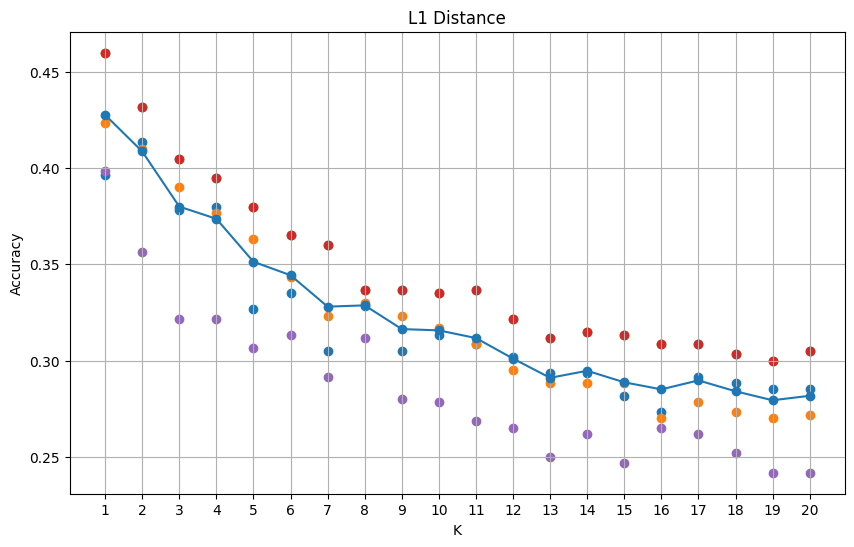

For L2 Distance:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.3133, 0.2983, 0.2367, 0.24, 0.235, 0.225, 0.1933, 0.2017, 0.1617, 0.1667, 0.155, 0.1517, 0.1483, 0.165, 0.1533, 0.1567, 0.135, 0.14, 0.125, 0.1317]
Max accuracy:  0.3133
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.3067, 0.295, 0.2783, 0.235, 0.2367, 0.2017, 0.2, 0.19, 0.165, 0.1483, 0.1517, 0.1283, 0.1083, 0.125, 0.1033, 0.105, 0.0933, 0.095, 0.0917, 0.09]
Max accuracy:  0.3067
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.33, 0.305, 0.28, 0.2333, 0.23, 0.21, 0.1883, 0.165, 0.16, 0.165, 0.1333, 0.1417, 0.1267, 0.1583, 0.13, 0.1317, 0.125, 0.1383, 0.1233, 0.1283]
Max accuracy:  0.33
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.33, 0.305, 0.28, 0.2333, 0.23, 0.21, 0.1883, 0.165, 0.16, 0.165, 0.1333, 0.1417, 0.1267, 0.1583, 0.13, 0.1317, 0.125, 0.1383, 0.1233, 0.1283]
Max accuracy:  0.33
[1, 2, 3, 4, 5, 6, 7, 

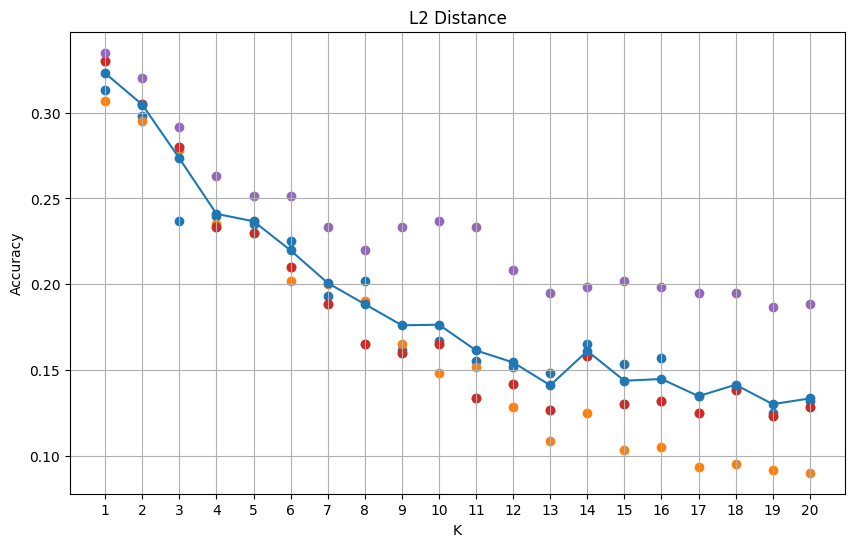

In [15]:
print("For L1 Distance:")
x_list = list(range(1, k_range+1))
plt.figure(figsize=(10, 6))

for fold in accuracies:
  y_list = fold[0]
  print(x_list)
  numbers = y_list
  rounded_numbers = [round(num, 4) for num in numbers]
  print(rounded_numbers)
  print("Max accuracy: ", max(rounded_numbers))
  plt.scatter(x_list, y_list)
  
arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend, fmt='-o')
plt.title('L1 Distance')
# Sets the X-axis ticks to the values in x_list (K values).
plt.xticks(x_list)             
# Enables a grid on the plot for better readability.                            
plt.grid(True)                                              
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()


print("For L2 Distance:")
x_list = list(range(1, k_range+1))
plt.figure(figsize=(10, 6))

for fold in accuracies:
  y_list = fold[1]
  print(x_list)
  numbers = y_list
  rounded_numbers = [round(num, 4) for num in numbers]
  print(rounded_numbers)
  print("Max accuracy: ", max(rounded_numbers))
  plt.scatter(x_list, y_list)
  
arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend, fmt='-o')
plt.title('L2 Distance')
# Sets the X-axis ticks to the values in x_list (K values).
plt.xticks(x_list)        
# Enables a grid on the plot for better readability.                                   
plt.grid(True)                                               
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

## <b>Top 5 Prediction</b>

<p>
<code>l1_dist</code> Calculates the sum of absolute differences between pixel values of two images. <br>
<code>l2_dist</code> Calculates the Euclidean distance between two images.

Iterates over each test image, Calculates distance between the test image and every training image. Stores the distances and corresponding class labels in a list. Sorts the list based on distances. Prints the top 5 predicted classes with their corresponding L1 & L2 distances.
</p>

Top 5 Predictions for L1 Distance:
Prediction 1: Class 'dogs' with L1 distance 0.00
Prediction 2: Class 'cats' with L1 distance 821.24
Prediction 3: Class 'dogs' with L1 distance 947.53
Prediction 4: Class 'dogs' with L1 distance 947.92
Prediction 5: Class 'panda' with L1 distance 950.37

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'dogs' with L2 distance 0.00
Prediction 2: Class 'cats' with L2 distance 313.75
Prediction 3: Class 'panda' with L2 distance 313.76
Prediction 4: Class 'panda' with L2 distance 314.72
Prediction 5: Class 'cats' with L2 distance 314.89


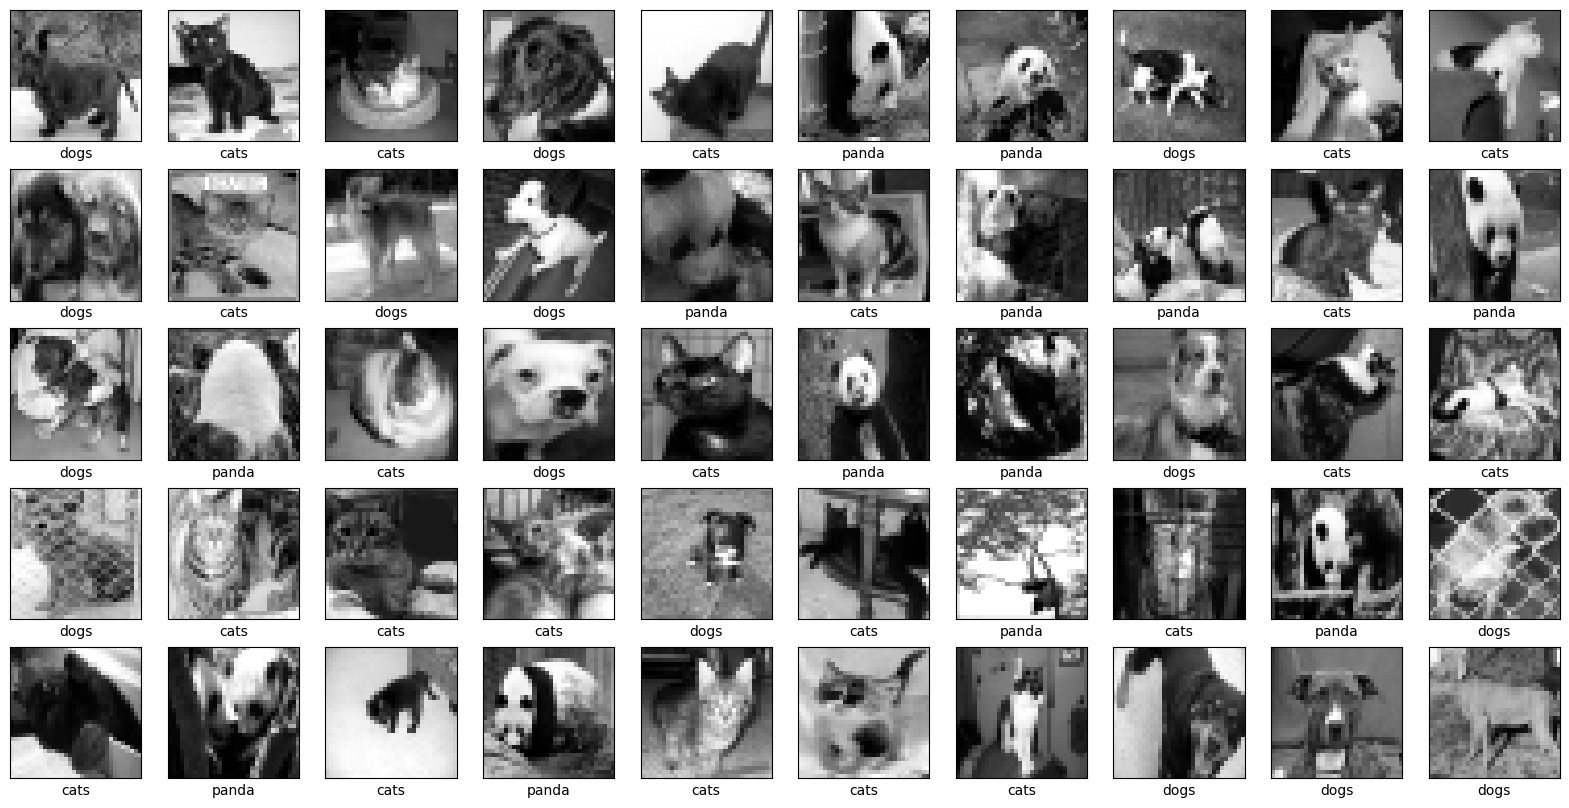

In [16]:
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 49: 
        break
    
test_images = [] 

for i in range(3000):
    test_image = TRAIN_DATA[i][0] 
    test_image_gray = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY) 
    test_images.append(test_image_gray) 

print("Top 5 Predictions for L1 Distance:")
for test_image_gray in test_images:
    distances1 = []                                                            
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY) 
        dist1 = l1_dist(test_image_gray, train_image_gray) 
        # A tuple containing a distance and a class number.
        distances1.append((dist1, class_num))     
    # Will return the distance value for each tuple.                             
    distances1.sort(key=lambda x: x[0])                                        
    
    for i, (dist1, class_num) in enumerate(distances1[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")
    break
    

print("\nTop 5 Predictions for L2 Distance:")
for test_image_gray in test_images:
    distances2 = []                                                            
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY) 
        dist2 = l2_dist(test_image_gray, train_image_gray) 
        # A tuple containing a distance and a class number.
        distances2.append((dist2, class_num))                
    # Will return the distance value for each tuple.                  
    distances2.sort(key=lambda x: x[0])                                        

    for i, (dist2, class_num) in enumerate(distances2[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")   
    break

## <b>Verification</b>

<p>
A list <code>prediction_classes</code> containing the labels of the neighbours closest training images. <br>
<code>occurrences_dict</code> to store class counts and distance sums. Counts the occurrences of each class in prediction_classes and calculates the sum of distances for each class.
</p>

Classes with their number of occurances: {'cats': [1, 0.0], 'panda': [1, 309.3541659651604], 'dogs': [1, 309.3945700880996]}
max number of at common class: 1
highest probable class: ['cats', 'panda', 'dogs']
Class with the least error: (['cats'], 0.0)


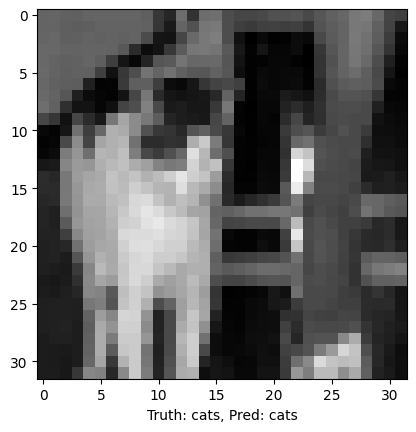


Classes with their number of occurances: {'panda': [2, 313.3496449654922], 'dogs': [1, 312.91372612910413]}
max number of at common class: 2
highest probable class: ['panda']


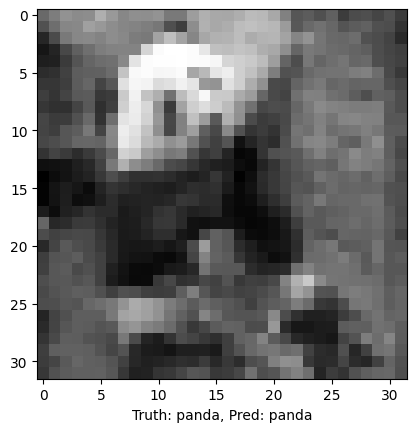


Classes with their number of occurances: {'dogs': [2, 307.632898110719], 'cats': [1, 308.24827655641485]}
max number of at common class: 2
highest probable class: ['dogs']


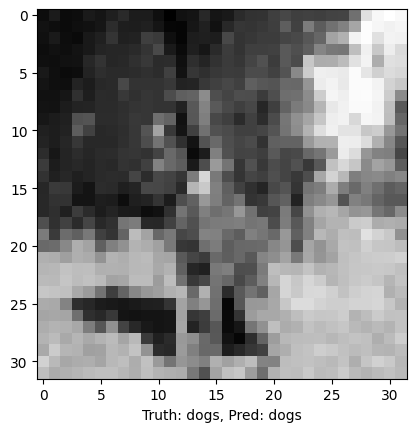


Classes with their number of occurances: {'dogs': [2, 314.2451272494134], 'cats': [1, 313.6383267395743]}
max number of at common class: 2
highest probable class: ['dogs']


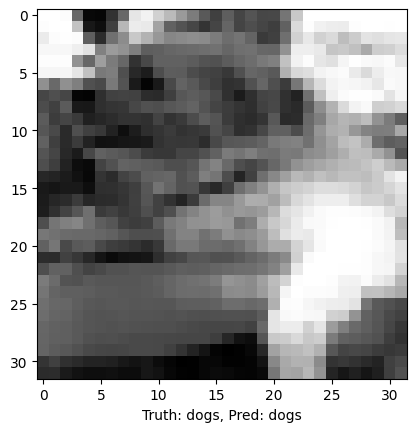


Classes with their number of occurances: {'cats': [2, 281.52797374328543], 'dogs': [1, 281.8900494873844]}
max number of at common class: 2
highest probable class: ['cats']


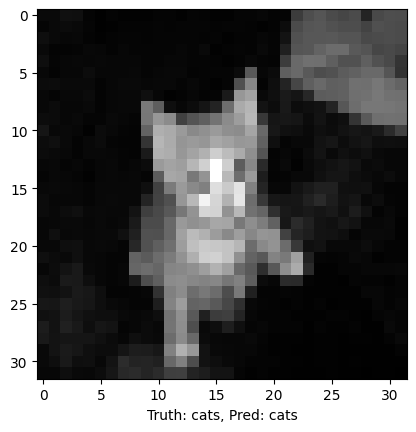


Classes with their number of occurances: {'panda': [1, 0.0], 'dogs': [2, 584.6541584835495]}
max number of at common class: 2
highest probable class: ['dogs']


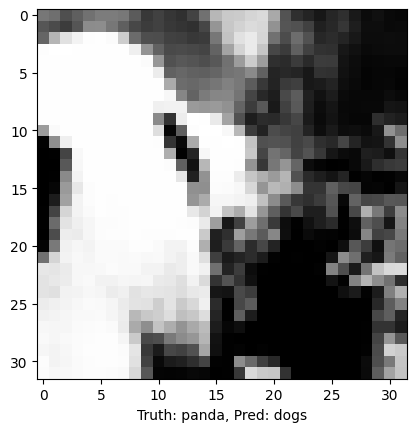


Classes with their number of occurances: {'dogs': [2, 312.9360957128468], 'cats': [1, 312.3795767972036]}
max number of at common class: 2
highest probable class: ['dogs']


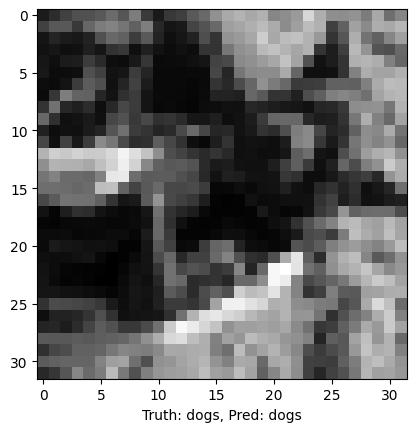


Classes with their number of occurances: {'panda': [2, 307.7693941898707], 'dogs': [1, 311.66969695496545]}
max number of at common class: 2
highest probable class: ['panda']


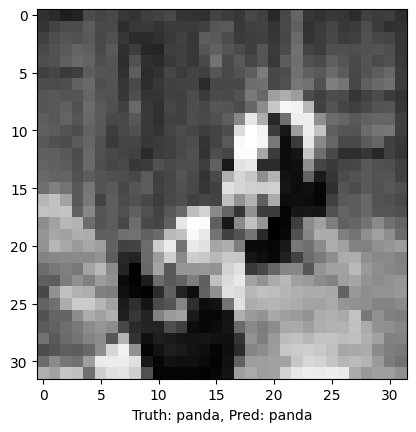


Classes with their number of occurances: {'cats': [1, 0.0], 'dogs': [2, 625.4024376320085]}
max number of at common class: 2
highest probable class: ['dogs']


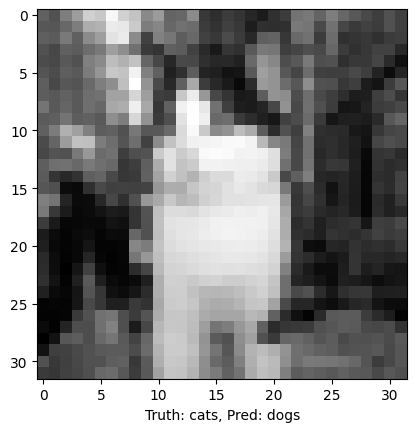


Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [2, 610.2202281613143]}
max number of at common class: 2
highest probable class: ['cats']


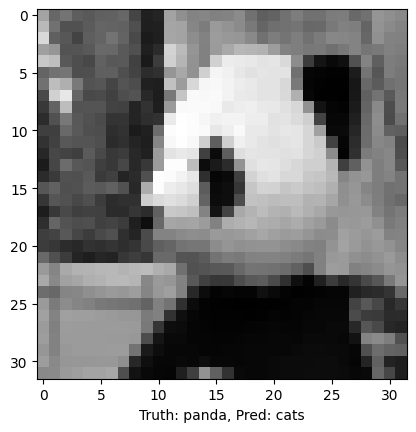


Classes with their number of occurances: {'panda': [1, 0.0], 'dogs': [1, 312.61477892127874], 'cats': [1, 313.12297903539434]}
max number of at common class: 1
highest probable class: ['panda', 'dogs', 'cats']
Class with the least error: (['panda'], 0.0)


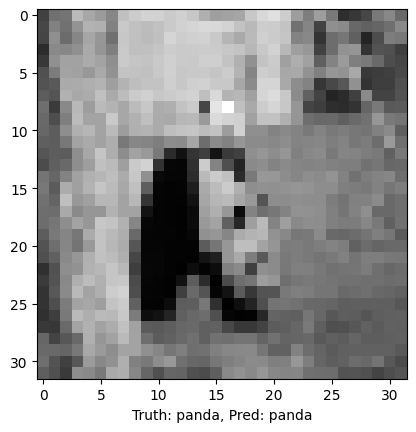


Classes with their number of occurances: {'panda': [2, 312.86418778760856], 'cats': [1, 310.99356906534257]}
max number of at common class: 2
highest probable class: ['panda']


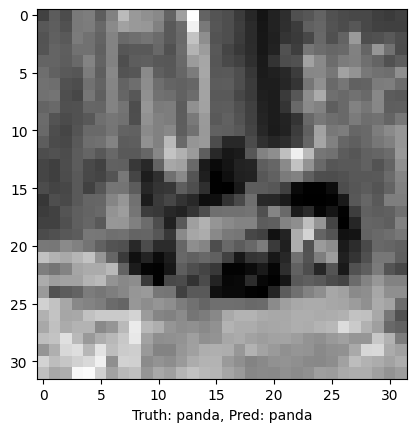


Classes with their number of occurances: {'dogs': [2, 302.801915449688], 'cats': [1, 302.5822202311299]}
max number of at common class: 2
highest probable class: ['dogs']


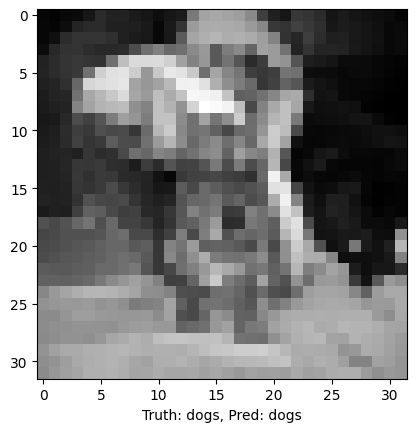


Classes with their number of occurances: {'panda': [1, 0.0], 'dogs': [2, 626.8041557159462]}
max number of at common class: 2
highest probable class: ['dogs']


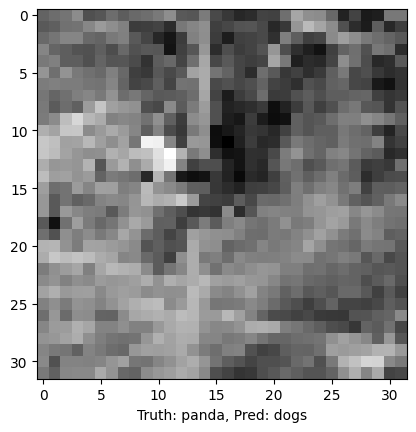


Classes with their number of occurances: {'cats': [3, 596.5539745544352]}
max number of at common class: 3
highest probable class: ['cats']


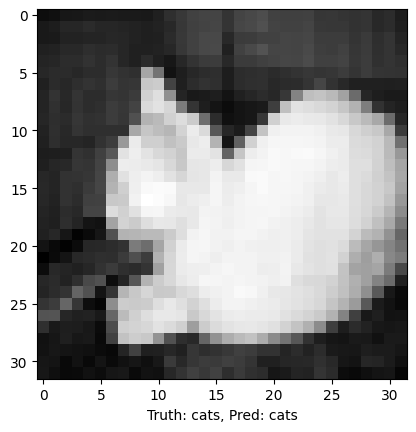


Correctly predicted 11 images out of 15, overall accuracy: 73.33333333333333 %


In [17]:
random.shuffle(TRAIN_DATA)

test_images = []
neighbours = 3
test_count = 15

for i in range(test_count):
    test_image = TRAIN_DATA[i][0]
    test_image_gray = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)
    test_images.append([test_image_gray, TRAIN_DATA[i][1]])

accurate = 0

for test_image_gray in test_images:
    distances2 = []
    pred = None
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray[0], train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    prediction_classes = [[cl[0], CATEGORIES[cl[1]]] for cl in distances2[:neighbours]]
    occurrences_dict = {pc[1]: [0,0] for pc in prediction_classes}
    for pc in prediction_classes:
      if pc[1] in occurrences_dict:
          occurrences_dict[pc[1]][0] = occurrences_dict[pc[1]][0] + 1
          occurrences_dict[pc[1]][1] += pc[0]
      else:
          occurrences_dict[pc[1]][0] = 1
          occurrences_dict[pc[1]][1] += pc[0]

    print(f'Classes with their number of occurances: {occurrences_dict}')

    elements_at_index_0 = [value[0] for value in occurrences_dict.values()]
    max_count_0 = max(elements_at_index_0)
    print(f'max number of at common class: {max_count_0}')

    keys_with_max_value = [key for key, value in occurrences_dict.items() if value[0] == max_count_0]
    print(f'highest probable class: {keys_with_max_value}')

    if len(keys_with_max_value) == 1:
      pred = keys_with_max_value[0]
    else:
      elements_at_index_1 = [value[1] for value in occurrences_dict.values()]
      min_count_1 = min(elements_at_index_1)

      keys_with_min_value = [key for key, value in occurrences_dict.items() if value[1] == min_count_1]
      pred = keys_with_min_value[0]
      print(f'Class with the least error: {keys_with_min_value, min_count_1}')


    truth = CATEGORIES[test_image_gray[1]]
    plt.figure()
    plt.imshow(test_image_gray[0], cmap="gray")
    plt.xlabel(f"Truth: {truth}, Pred: {pred}")
    plt.show()
    
    if truth == pred: 
      accurate += 1
    for i in range(1): 
      print()


print(f'Correctly predicted {accurate} images out of {test_count}, overall accuracy: {(accurate/test_count)*100} %')